# _PyChOpMarg_ Testing & Debugging Notebook

Original author: [David Banas](mailto:capn.freako@gmail.com)  
Original date:   March 3, 2024

Copyright &copy; 2024 David Banas; all rights reserved World wide.


## Introduction

This [Jupyter](https://jupyter.org) notebook was created to help test and debug a new Python package: [_PyChOpMarg_](), which implements the _Channel Operating Margin_ (COM) specification, as given by: [IEEE 802.3-22](https://ieeexplore.ieee.org/document/9844436) **Annex 93A**.

The _PyChOpMarg_ package offers 3 different operating modes:

1. Desktop GUI application,
2. Command line utility, and
3. Library for importing into higher-level scripts and/or notebooks like this one.

This notebook serves double duty as an example of using _PyChOpMarg_ as a library.
In particular, here I run a comparison of the _PyChOpMarg_ COM results to those given to me by Bob Sullivan of the [VITA](https://www.vita.com/VITA68) organization, for the purposes of testing and correlation.

## Executive Summary

As of **Saturday, March 23, 2024**:

- I still don't have very good agreement w/ Bob's results, but I think I've identified the major sources of discrepancy.

- My COM numbers are consistently higher than Bob's, despite our FOM numbers agreeing very well.  
And this seems to be due to my calculated $A_{ni}$ numbers being too low.

- The primary contributor to my low noise numbers seems to be crosstalk.
And my low numbers here, relative to Bob's, appear to be caused by a deviation in the MATLAB code (v2.60) from the official specification (IEEE 802.3-22 Annex 93A).  
(See _Appendix A_ for more detail.)


## COM Parameters & Bob's Results

Here, I define the COM parameters according to Bob's configuration and capture his results, for comparison later.
The two sets of results correspond to package choices 1 and 2, respectively.

**Note:** Bob's configuration is contained in the `config_com_ieee8023_93a=100GBASE-KR4.xls` file.

**Note:** Bob is using the multiple s4p files option.  
(So, if you're primarily interested in comparing my results to Bob's, skip ahead to _Example 2_.)

In [1]:
params = {  # IEEE-802.3by
    # General
    "fb": 25.78125,  # (GBaud)
    "fstep": 10e6,   # (Hz)
    "L": 2,
    "M": 32,
    "DER_0": 1e-5,
    "RLM": 1.0,
    "A_v":  0.4,  # victim
    "A_fe": 0.4,  # far end aggressor
    "A_ne": 0.6,  # near end aggressor
    "R_0": 50,    # system reference impedance (Ohms)
    # Noise
    "A_DD": 0.05,  # (UI)
    "SNR_TX": 27,  # (dB)
    "eta_0": 5.20E-08,  # (V^2/GHz)
    "sigma_Rj": 0.01,  # (UI)
    # CTLE
    "f_z":   6.4453125,  # (GHz)
    "f_p1":  6.4453125,  # (GHz)
    "f_p2": 25.78125,  # (GHz)
    "f_LF": 0.001,  # (GHz)
    "g_DC": [-n for n in range(13)], # (dB)
    "g_DC2": [0], # (dB)
    # Tx FFE
    #          c(-1)  c(+1)
    "tx_taps_min": [0, 0, -0.18, -0.38, 0, 0],
    "tx_taps_max": [0, 0,  0.00,  0.00, 0, 0],
    "tx_taps_step": [0, 0, 0.02,  0.02, 0, 0],
    "c0_min": 0.62,
    # Rx DFE
    "f_r": 0.75,  # (fb)
    "dfe_min": [-1.0]*14,
    "dfe_max": [ 1.0]*14,
    # Die & Package
    "R_d": 55,     # (Ohms)
    "C_d": [0.250],  # (pF)
    "C_b": 0.001,  # (pF)
    "C_p": 0.180,  # (pF)
    "L_s": [0.000],  # (nH)
    "z_c": [78.2],     # (Ohms)
    "z_p": [12, 30],    # (mm)
    "gamma0": 5.0e-4,           # (1/mm)
    "a1":     8.9e-4,           # (sqrt_ns/mm)
    "a2":     2.0e-4,            # (ns/mm)
    "tau":    6.141e-3,          # (ns/mm)
}

bobs_rslts = [
    {
    'com': 4.3,          # (dB)
    'fom': 16.9,         # (dB)
    'As': 30.3,          # (mV)
    'Ani': 18.5,         # (mV)
    'vic_pulse_pk': 82.6,  # (mV)
    'gDC': -12,          # (dB)
    'tx_taps': [-0.16, 0],
    'dfe_taps': [0.577, 0.034, 0.000, -0.070],
    'sigma_ISI': 1.8, # (mV)
    'sigma_XT': 3.3,  # (mV)
    'sigma_G': 1.6,   # (mV)
    'sigma_Tx': 1.4,  # (mV)
    'sigma_J': 0.40,  # (mV)
    'sigma_N': 0.71,  # (mV)
    },
    {
    'com': 3.65,         # (dB)
    'fom': 16.25,        # (dB)
    'As': 25,            # (mV)
    'Ani': 16.46,         # (mV)
    'vic_pulse_pk': 72,  # (mV)
    'gDC': -12,          # (dB)
    'tx_taps': [-0.16, 0],
    'dfe_taps': [0.684, 0.106, 0.014, 0.010],
    'sigma_ISI': 1.9, # (mV)
    'sigma_XT': 2.8,  # (mV)
    'sigma_G': 1.4,   # (mV)
    'sigma_Tx': 1.1,  # (mV)
    'sigma_J': 0.33,  # (mV)
    'sigma_N': 0.71,  # (mV)
    },
]

## Utility Functions

These functions provide general utility for the rest of this notebook.

In [2]:
%matplotlib inline

import numpy as np

from IPython.core.magic import register_cell_magic

from matplotlib         import pyplot as plt
from scipy.interpolate  import interp1d

from pychopmarg.com     import COM
from pychopmarg.utility import calc_Hffe


@register_cell_magic
def skip(line, cell):
    return


def print_results(theCOM: COM, zp_sel: int) -> None:
    """
    Print the results of a called `COM` instance,
    comparing to Bob's own results for the given case.

    Args:
        theCOM: The `COM` instance of interest; must've been previously called!
        zp_sel: The package case to use.

    Returns:
        None
    """
    
    print("Metric\t\tBob's Value\tMy Value\tError")
    print("=" * 53)
    for key in bobs_rslts[zp_sel-1].keys():
        print(f"{key}:\t", end="")
        if len(key) < 7:
            print("\t", end="")
        bobs = bobs_rslts[zp_sel-1][key]
        mine = theCOM.rslts[key]
        if key.endswith("taps"):
            print("")
            for n, (bob, me) in enumerate(zip(bobs, mine)):
                if bob:
                    err = (me - bob)/bob
                else:
                    err = 1
                print(f"\t{n+1}:\t", end="")
                print(f"{bob:11.2f}\t{me:8.2f}\t{err*100:4.0f}%")
        else:
            err = (mine - bobs)/bobs
            print(f"{bobs:11.2f}\t{mine:8.2f}\t{err*100:4.0f}%")

def plot_cdf(theCOM: COM) -> None:
    """
    Plot the combined noise-xtalk-interference CDF of a called `COM` instance,
    showing where it crosses the DER threshold.

    Args:
        theCOM: The `COM` instance of interest; must've been previously called!
    """
    
    y = theCOM.rslts['y']
    Py = theCOM.rslts['Py']
    Ani = y[np.where(Py > theCOM.DER0)[0][0]]
    plt.plot(y*1e3, Py)
    plt.axvline(Ani*1e3, color='black', linestyle='dashed')
    plt.title("Noise & Interference CDF Showing DER Threshold Crossing")
    plt.xlabel("Value (mV)")
    plt.grid()
    plt.show()

def plot_pulse_resps(theCOM: COM) -> None:
    """
    Plot the victim pulse response, in its 3 stages of evolution:
    
    1. before adding the packaging,
    2. after adding packaging, but before adding EQ, and
    3. after adding EQ.

    Args:
        theCOM: A COM instance, which has been previously called,
            in order to generate the required preliminaries.
    """
    
    gDC = theCOM.rslts['gDC']
    gDC2 = theCOM.rslts['gDC2']
    tx_taps = np.array(theCOM.tx_taps).flatten()
    cursor_ix = theCOM.com_cursor_ix
    
    print("Using these optimizer selected linear EQ values:")
    print(f"\tgDC:\t\t{gDC:3.0f} dB")
    print(f"\tgDC2:\t\t{gDC2:3.0f} dB")
    print("\tTx tap weights:", end="")
    for w in tx_taps:
        print(f" {w:6.3f}", end="")
    print("")
    print("")

    # Plot the equalized victim pulse response.
    theCOM.gDC = gDC
    theCOM.gDC2 = gDC2
    pulse_resps = theCOM.gen_pulse_resps(tx_taps=np.array(tx_taps))
    x = pulse_resps[0]  # victim
    t = theCOM.times
    dfe_end = t[cursor_ix] + theCOM.nDFE/theCOM.params['fb']/1e9
    plt.plot(t*1e9, x[:len(t)]*1e3, label="Equalized")
    plt.axvline(t[cursor_ix]*1e9, color='black', linestyle='dashed')
    plt.axvline(dfe_end*1e9, color='black', linestyle='dashed')
    
    # Plot the pre-package and unequalized victim pulse responses.
    plt.plot(t*1e9, theCOM.pulse_resps_nopkg[0][:len(t)]*1e3, label="NoPkg")
    plt.plot(t*1e9, theCOM.pulse_resps_noeq[0][:len(t)]*1e3, label="NoEQ")
    
    plt.title("Victim Pulse Responses Showing Cursor Location & DFE Range")
    plt.xlabel("Time (ns)")
    plt.ylabel("p(t) (mV)")
    plt.axis(xmin=0, xmax=2)  # Set after viewing the unconstrained plot.
    plt.legend()
    plt.show()

def plot_freq_resps(theCOM: COM, zp_sel: int) -> None:
    """
    Plot the frequency responses of the various system components.

    Args:
        theCOM: A COM instance, which has been previously called,
            in order to generate the required preliminaries.
        zp_sel: The package option selector.
    """
    
    f = theCOM.freqs
    tx_taps = np.array(theCOM.tx_taps).flatten()
    plt.semilogx(f/1e9, 20*np.log10(np.abs(theCOM.H(theCOM.chnls[0][0], np.array(tx_taps)))), label="Hvic")
    plt.semilogx(f/1e9, 20*np.log10(np.abs(calc_Hffe(f, 1 / theCOM.fb, list(tx_taps), theCOM.tx_n_post))), label="Hffe")
    plt.semilogx(f/1e9, 20*np.log10(np.abs(theCOM.H21(theCOM.chnls[0][0]))), label="H21vic")
    plt.semilogx(f/1e9, 20*np.log10(np.abs(theCOM.Hr)), label="Hr")
    plt.semilogx(f/1e9, 20*np.log10(np.abs(theCOM.Hctf)), label="Hctf")
    plt.semilogx(f/1e9, 20*np.log10(np.abs(theCOM.Xsinc)), label="Xsinc")
    plt.semilogx(f/1e9, 20*np.log10(np.abs(theCOM.H21(theCOM.sPkgTx))), label="Hpkg")
    plt.title("System Frequency Responses w/ Optimum EQ")
    plt.xlabel("Frequency (GHz)")
    plt.axis(ymin=-40)
    plt.grid()
    plt.legend()
    plt.show()

def import_csv(fname: str) -> tuple[np.typing.NDArray[float], np.typing.NDArray[float]]:
    """
    Import a comma separated value (CSV) file, assuming time in the first column.

    Args:
        fname: The name of the file to import.

    Returns:
        (time, [vals]): A pair consisting of:
            - The time values indexing each row of the data.
            - A list of value arrays, each indexed by `time`.

    Raises:
        RuntimeError: If the shape of the data array is irregular.
    """

    labels = None
    time = []
    with open(fname, 'rt') as f:
        for n, line in enumerate(f):
            toks = line.split(', ')
            if n == 0:
                nVals = len(toks) - 1
                vals = [[]] * nVals
            if n == 0 and toks[0] is str:
                labels = list(map(str, toks))
            else:
                nToks = len(toks)
                assert nToks == nVals+1, f"Line {n+1} has the wrong number of tokens (Expecting: {nVals}; got: {nToks})!"
                time.append(float(toks[0]))
                for n in range(nVals):
                    vals[n].append(float(toks[n+1]))
    return (np.array(time), list(map(np.array, vals)))


## Example 1 - s32p Channel File, as per VITA 68.2

This example shows how to use the _PyChOpMarg_ package as a library, for measuring the COM of a 32-port [_Touchstone_ file](https://en.wikipedia.org/wiki/Touchstone_file) organized as specified by the [VITA](https://www.vita.com/VITA68) 68.2 standard.


### Package Case 1

In [3]:
%%skip
theCOM_s32p_pkg1 = COM.init(params, ["chnl_data/example1.s32p"], 3, zp_sel=1, num_ui=500, gui=False)
com = theCOM_s32p_pkg1()


#### Tabulated Results

In [4]:
%%skip
print_results(theCOM_s32p_pkg1, 1)

#### NIC CDF

In [5]:
%%skip
plot_cdf(theCOM_s32p_pkg1)

#### Pulse Responses

In [6]:
%%skip
plot_pulse_resps(theCOM_s32p_pkg1)

#### Frequency Responses

In [7]:
%%skip
plot_freq_resps(theCOM_s32p_pkg1, 1)

### Package Case 2

In [8]:
%%skip
theCOM_s32p_pkg2 = COM.init(params, ["chnl_data/example1.s32p"], 3, zp_sel=2, num_ui=500, gui=False)
com = theCOM_s32p_pkg2()

#### Tabulated Results

In [9]:
%%skip
print_results(theCOM_s32p_pkg2, 2)

#### NIC CDF

In [10]:
%%skip
plot_cdf(theCOM_s32p_pkg2)

#### Pulse Responses

In [11]:
%%skip
plot_pulse_resps(theCOM_s32p_pkg2)

#### Frequency Responses

In [12]:
%%skip
plot_freq_resps(theCOM_s32p_pkg2, 2)

## Example 2 - 6 x s4p Channel Files, as per VITA 68.2

Here, we're testing the same channel as above in _Example_1_, but using 6 s4p files, instead of a single s32p file.

In [13]:
chnl_files = [
    "chnl_data/example2_THRU.s4p",
    "chnl_data/example2_FEXT1.s4p",
    "chnl_data/example2_FEXT2.s4p",
    "chnl_data/example2_NEXT1.s4p",
    "chnl_data/example2_NEXT2.s4p",
    "chnl_data/example2_NEXT3.s4p",
]

### Package Case 1

In [14]:
theCOM_6xs4p_pkg1 = COM.init(params, chnl_files, 3, zp_sel=1, num_ui=500, gui=False)
com = theCOM_6xs4p_pkg1()


#### Tabulated Results

In [15]:
print_results(theCOM_6xs4p_pkg1, 1)

Metric		Bob's Value	My Value	Error
com:		       4.30	    0.00	-100%
fom:		      16.90	   49.44	 193%
As:		      30.30	   52.93	  75%
Ani:		      18.50	   52.93	 186%
vic_pulse_pk:	      82.60	   68.81	 -17%
gDC:		     -12.00	  -12.00	  -0%
tx_taps:	
	1:	      -0.16	   -0.12	 -25%
	2:	       0.00	   -0.26	 100%
dfe_taps:	
	1:	       0.58	    0.06	 -90%
	2:	       0.03	   -0.24	-795%
	3:	       0.00	   -0.11	 100%
	4:	      -0.07	    0.04	-158%
sigma_ISI:	       1.80	    1.09	 -39%
sigma_XT:	       3.30	    2.78	 -16%
sigma_G:	       1.60	   44.67	2692%
sigma_Tx:	       1.40	   44.67	3091%
sigma_J:	       0.40	    1.03	 157%
sigma_N:	       0.71	    0.00	-100%


#### NIC CDF

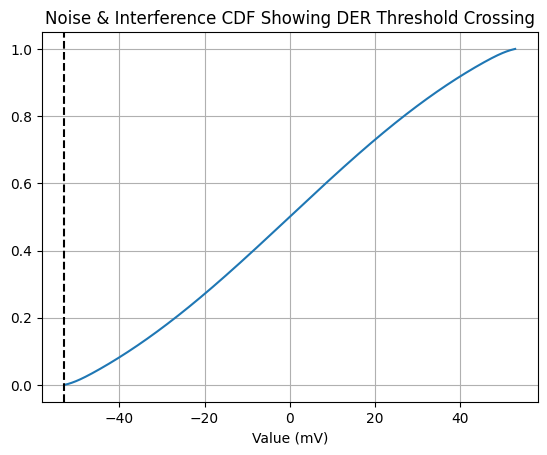

In [16]:
plot_cdf(theCOM_6xs4p_pkg1)

#### Pulse Responses

Using these optimizer selected linear EQ values:
	gDC:		-12 dB
	gDC2:		  0 dB
	Tx tap weights:  0.000  0.000 -0.120 -0.260  0.000  0.000



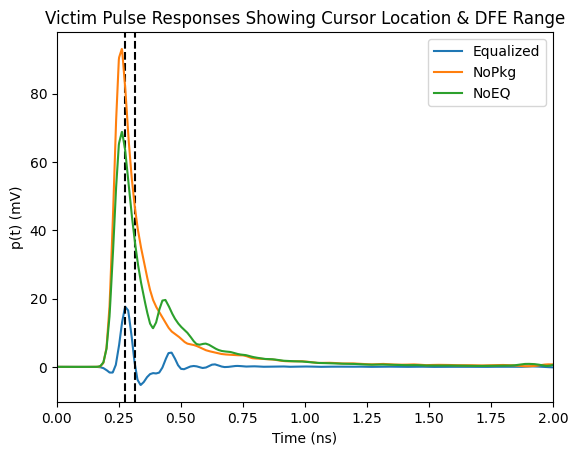

In [17]:
plot_pulse_resps(theCOM_6xs4p_pkg1)

#### Frequency Responses

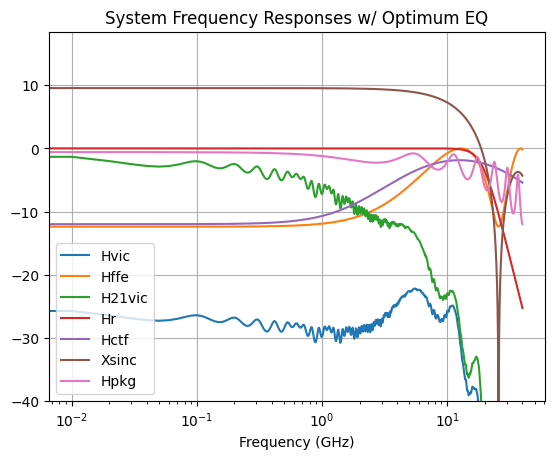

In [18]:
plot_freq_resps(theCOM_6xs4p_pkg1, 1)

### Package Case 2

In [19]:
theCOM_6xs4p_pkg2 = COM.init(params, chnl_files, 3, zp_sel=2, num_ui=500, gui=False)
com = theCOM_6xs4p_pkg2()

#### Tabulated Results

In [20]:
print_results(theCOM_6xs4p_pkg2, 2)

Metric		Bob's Value	My Value	Error
com:		       3.65	    0.00	-100%
fom:		      16.25	   50.09	 208%
As:		      25.00	   43.32	  73%
Ani:		      16.46	   43.32	 163%
vic_pulse_pk:	      72.00	   61.38	 -15%
gDC:		     -12.00	  -12.00	  -0%
tx_taps:	
	1:	      -0.16	   -0.06	 -62%
	2:	       0.00	   -0.32	 100%
dfe_taps:	
	1:	       0.68	    0.26	 -63%
	2:	       0.11	   -0.36	-436%
	3:	       0.01	   -0.10	-821%
	4:	       0.01	    0.01	  -8%
sigma_ISI:	       1.90	    1.09	 -43%
sigma_XT:	       2.80	    2.45	 -12%
sigma_G:	       1.40	   44.67	3091%
sigma_Tx:	       1.10	   44.67	3961%
sigma_J:	       0.33	    1.18	 257%
sigma_N:	       0.71	    0.00	-100%


#### NIC CDF

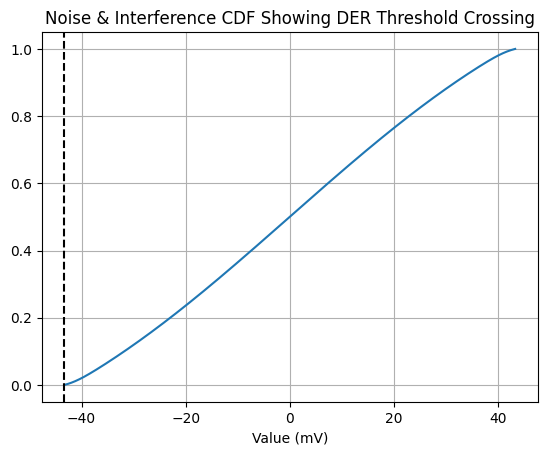

In [21]:
plot_cdf(theCOM_6xs4p_pkg2)

#### Pulse Responses

Using these optimizer selected linear EQ values:
	gDC:		-12 dB
	gDC2:		  0 dB
	Tx tap weights:  0.000  0.000 -0.060 -0.320  0.000  0.000



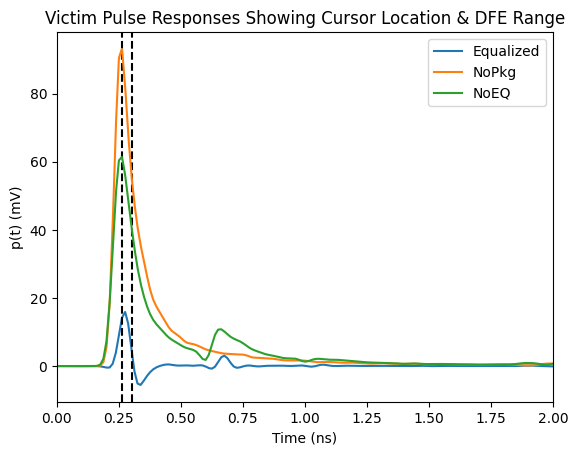

In [22]:
plot_pulse_resps(theCOM_6xs4p_pkg2)

#### Frequency Responses

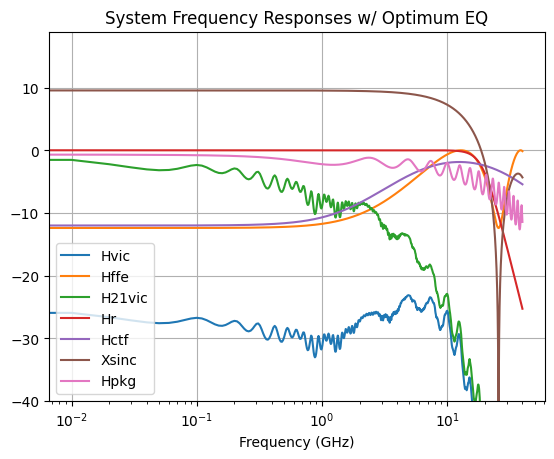

In [23]:
plot_freq_resps(theCOM_6xs4p_pkg2, 2)

## General Conclusion

My `COM` values are consistently slightly higher than Bob's, despite the excellent agreement between our `FOM` values.
The reason for this seems to be my calculated values for $A_{ni}$, which are consistently slightly lower than Bob's.  
(My $A_s$ values are also lower, but not by nearly as much.)

The culprit would appear to be my calculated _crosstalk_ values.
They are the most significant noise contributor.
And my values are consistently lower than Bob's, which would explain my lower $A_{ni}$ values.

**Indeed, digging into the MATLAB code reveals a significant recent divergence between its crosstalk calculation routine and the spec., which my Python code follows.**  
(See the _Crosstalk_ section of _Appendix A_, below.)


## Appendix A - Investigating Discrepancies

Here, I'm going to try to troubleshoot the various discrepancies between my calculated numbers and Bob's.
My hope is that by breaking the problem down into atomic components I can resolve the discrepancies.
My goals here, in descending order of priority, are:

1. Find a bug in my Python code that explains the observed discrepancy and fix it, confirming that the discrepancy has been eliminated.
2. Find a bug in the MATLAB code that I can defend and alert Rich Melitz to it, requesting a fix.
3. Generate plots and/or data, which will facilitate a meaningful discussion between me and Bob and Istvan and, hopefully, suggest next steps towards reconciliation.

### Forced EQ Match

Before I do anything else, I want to make sure that the discrepancies between our results isn't just due to the slight differences in our chosen linear EQ solutions.
So, here, I look at what happens when I bypass the EQ optimizer and just calculate COM using Bob's reported EQ solution.

**Note:** Ignore the `fom` parameter in the tabulated results below.
It's meaningless, since we aren't running EQ optimization in this case.

In [24]:
theCOM_6xs4p_pkg1.gDC = -12
theCOM_6xs4p_pkg1.gDC2 = 0
theCOM_6xs4p_pkg1.com = theCOM_6xs4p_pkg1(do_opt_eq=False, tx_taps=[0, 0, -0.16, 0, 0, 0])
print_results(theCOM_6xs4p_pkg1, 1)


Metric		Bob's Value	My Value	Error
com:		       4.30	    0.00	-100%
fom:		      16.90	   47.59	 182%
As:		      30.30	   79.76	 163%
Ani:		      18.50	   79.76	 331%
vic_pulse_pk:	      82.60	   68.81	 -17%
gDC:		     -12.00	  -12.00	  -0%
tx_taps:	
	1:	      -0.16	   -0.16	  -0%
	2:	       0.00	    0.00	 100%
dfe_taps:	
	1:	       0.58	    0.48	 -17%
	2:	       0.03	   -0.01	-118%
	3:	       0.00	   -0.11	 100%
	4:	      -0.07	    0.01	-112%
sigma_ISI:	       1.80	    2.02	  12%
sigma_XT:	       3.30	    2.83	 -14%
sigma_G:	       1.60	   44.67	2692%
sigma_Tx:	       1.40	   44.67	3091%
sigma_J:	       0.40	    1.28	 220%
sigma_N:	       0.71	    0.00	-100%


In [25]:
theCOM_6xs4p_pkg2.gDC = -12
theCOM_6xs4p_pkg2.gDC2 = 0
theCOM_6xs4p_pkg2.com = theCOM_6xs4p_pkg2(do_opt_eq=False, tx_taps=[0, 0, -0.16, 0, 0, 0])
print_results(theCOM_6xs4p_pkg2, 2)


Metric		Bob's Value	My Value	Error
com:		       3.65	    0.00	-100%
fom:		      16.25	   48.13	 196%
As:		      25.00	   66.98	 168%
Ani:		      16.46	   66.98	 307%
vic_pulse_pk:	      72.00	   61.38	 -15%
gDC:		     -12.00	  -12.00	  -0%
tx_taps:	
	1:	      -0.16	   -0.16	  -0%
	2:	       0.00	    0.00	 100%
dfe_taps:	
	1:	       0.68	    0.60	 -12%
	2:	       0.11	    0.04	 -63%
	3:	       0.01	   -0.05	-449%
	4:	       0.01	   -0.01	-219%
sigma_ISI:	       1.90	    2.01	   6%
sigma_XT:	       2.80	    2.49	 -11%
sigma_G:	       1.40	   44.67	3091%
sigma_Tx:	       1.10	   44.67	3961%
sigma_J:	       0.33	    1.44	 337%
sigma_N:	       0.71	    0.00	-100%


Okay, the discrepancies in our calculated values have nothing to do with the differences in our EQ solutions.

### ISI

Here, I'm going to focus on the discrepancy between our `sigma_ISI` numbers.

**Note:** This one has actually been solved.
I've left the following in place, for reference.

#### FOM Code Comparison

Here, I'm just sanity checking my own code, against the spec., and looking for any differences between my implementation and the MATLAB code.

**Note:** This code comparison refers to the FOM calculation code only, because I'm trying to explain a discrepancy in our `sigma_ISI` numbers and only the FOM calculation treats ISI statistically.
The actual noise calculation incorporates ISI explicitly.
(See below.)

First, for reference, the spec.:

$$
\begin{equation}
  h_{ISI}(n) =
  \begin{cases}
    0 & \text{n = 0} \\
    h^{(0)}(t_s + nT_b) - h^{(0)}(t_s) b(n) & \text{1 $\leq$ n $\leq$ $N_b$} \\
    h^{(0)}(t_s + nT_b) & \text{otherwise}
  \end{cases}
  \qquad \text{(93A-27)}
\end{equation}
$$

$$
\sigma^2_{ISI} = \sigma^2_X \sum_n h^2_{ISI}(n) \qquad \text{(93A-31)}
$$

Next, my Python code:

```python
        # Step e - ISI.
        vic_pulse_resp_post_samps = vic_pulse_resp[cursor_ix+M::M]
        dfe_tap_weights = np.maximum(  # (93A-26)
            self.params['dfe_min'],
            np.minimum(
                self.params['dfe_max'],
                (vic_pulse_resp_post_samps[:nDFE] / vic_curs_val)))
        hISI = vic_pulse_resp_post_samps \
             - vic_curs_val * np.pad( dfe_tap_weights
                                    , (0, len(vic_pulse_resp_post_samps) - nDFE)
                                    , mode='constant'
                                    , constant_values=0 )  # (93A-27)
        varISI = varX * sum(hISI**2)  # (93A-31)
```

And, finally, the MATLAB code (v2.60):

```matlab
%% Equation 93A-27 "otherwise" case %%
far_cursors = sbr(cursor_i+param.samples_per_ui*(param.ndfe+1):param.samples_per_ui:end);
t=((cursor_i+param.samples_per_ui*(param.ndfe+1):param.samples_per_ui:length(sbr))-(cursor_i+param.samples_per_ui*(param.ndfe+1)))*...
    param.ui/param.samples_per_ui;
precursors = sbr(cursor_i-param.samples_per_ui:-param.samples_per_ui:1);
precursors = precursors(end:-1:1);

%% Equation 93A-31 %%
sigma_ISI = param.sigma_X*norm([precursors; excess_dfe_cursors; far_cursors]);
ISI_N=param.sigma_X*norm( far_cursors);
```

Aha! The MATLAB code is including _pre-cursors_.
(I wondered about that.)
That's _not_ consistent w/ the spec., but let's try it and see if we get a match.  
Yep, that brought me to within 2% of Bob's `sigma_ISI` number, for package option 2.

#### Effect on Noise Calculation

Making a similar change to the noise calculation code has improved things, bringing my final $A_{ni}$ and $COM$ results more inline w/ Bob's, but a significant discrepancy in both remains.

### Crosstalk

Next, I'll focus on crosstalk.
Again, I'll separate the effort into FOM and noise calculation inquiries.

#### FOM Code Comparison

First, the spec.:

$$
[\sigma_m^{(k)}]^2 = \sigma^2_X \sum_n [h^{(k)}((m/M + n) T_b)]^2 \qquad \text{(93A-33)}
$$

$$
\sigma^2_{XT} = \sum_{k=1}^{K-1} [\sigma_i^{(k)}]^2 \qquad \text{(93A-34)}
$$

where $i$ is chosen to maximize (93A-33).

Next, my Python code:

```python
# Step g - Crosstalk.
varXT = 0
for pulse_resp in pulse_resps[1:]:  # (93A-34)
    varXT += max([sum(np.array(self.filt_pr_samps(pulse_resp[m::M], As))**2)
                  for m in range(M)])  # (93A-33)
varXT *= varX
```

And, finally, the MATLAB code (v2.60):

```matlab
%% Equations 93A-33 and 93A-34 for FEXT (depends on TXFFE setting) %%
if OP.RX_CALIBRATION
    sigma_XT=0;
else  
    if ~OP.RxFFE
        % with three outputs, the sigma_XT includes both FEXT and NEXT
        % zhilei huang 01/11/2019
        [sigma_XT,~,~] =  get_xtlk_noise(txffe, 'FEXT', param ,chdata);
    else % John Ewen: 13/12/20018
        [sigma_XT,~,~] =  get_xtlk_noise(txffe, 'FEXT', param ,chdata, C);
    end
end

function [sigma_XT, sigma_FEXT, sigma_NEXT] = get_xtlk_noise( upsampled_txffe, type, param, chdata, C )
% Modified not to double count crosstalk: John Ewen 13/12/2018
% function sigma_XT = get_xtlk_noise( upsampled_txffe, type, param, chdata,ctle_indx,clow_indx, C,cursor_i)
index_f2=find(chdata(1).faxis(:)>param.fb,1,'first');
if isempty(index_f2), index_f2=length(chdata(1).faxis);end
f=chdata(1).faxis;
temp_angle=(param.samples_per_ui*param.sample_dt)*pi.*chdata(1).faxis;
if(f(1)==0)
    temp_angle(1)=1e-20;% we don't want to divide by zero
end
PWF_tx=ones(1,length(f));
if max(upsampled_txffe) > 0
    PWF_tx=zeros(1,length(f));
    [mcur,icur] = max(upsampled_txffe);
    for ii=1:length(upsampled_txffe)
        PWF_tx=upsampled_txffe(ii).*exp(-1j*2*pi*(ii-icur).*f/param.fb)+PWF_tx;
    end
end
PWF_rx=ones(1,length(f));
if exist('C','var')
    PWF_rx=zeros(1,length(f));
    for ii=-param.RxFFE_cmx:param.RxFFE_cpx
        PWF_rx=C(ii+param.RxFFE_cmx+1).*exp(-1j*2*pi*(ii+1).*f/param.fb)+PWF_rx;
    end
end
MDFEXT=0;MDNEXT=0;MDNEXT_ICN=0;MDFEXT_ICN=0;
for ii=2:size(chdata,2)
    SINC = sin(temp_angle)./temp_angle;
    PWF_data=SINC.^2;
    PWF=PWF_data.*PWF_rx; % power weight function
    PWFnext=abs(PWF);
    PWF=PWF_data.*PWF_rx.*PWF_tx; % power weight function
    PWFfext=abs(PWF);
    if isequal(chdata(ii).type, 'FEXT')
        MDFEXT=sqrt(abs(chdata(ii).sdd21ctf).^2+MDFEXT.^2); % power sum xtk
        MDFEXT_ICN=sqrt(2*chdata(ii).delta_f/param.fb*sum( chdata(ii).A^2*PWFfext(1:index_f2).*abs(MDFEXT(1:index_f2)).^2)); %eq 46
    elseif isequal(chdata(ii).type, 'NEXT')
        MDNEXT=sqrt(abs(chdata(ii).sdd21ctf).^2+MDNEXT.^2); % power sum xtk
        MDNEXT_ICN=sqrt(2*chdata(ii).delta_f/param.fb*sum( chdata(ii).A^2*PWFnext(1:index_f2).*abs(MDNEXT(1:index_f2)).^2)); %eq 47
    end
end
if nargout == 1 && isequal(type,'NEXT')
    sigma_XT = MDNEXT_ICN*sqrt((param.levels^2-1)/(3*(param.levels-1)^2));
elseif nargout == 1 && isequal(type,'FEXT')
    sigma_XT = MDFEXT_ICN*sqrt((param.levels^2-1)/(3*(param.levels-1)^2));
elseif nargout == 3
    sigma_XT=norm([ MDNEXT_ICN MDFEXT_ICN ])*sqrt((param.levels^2-1)/(3*(param.levels-1)^2));
    sigma_NEXT = MDNEXT_ICN*sqrt((param.levels^2-1)/(3*(param.levels-1)^2));
    sigma_FEXT = MDFEXT_ICN*sqrt((param.levels^2-1)/(3*(param.levels-1)^2));
end

function sigma_XT = get_xtlk_noise1( upsampled_txffe, type, param, chdata,C,cursor_i )
% calculate crosstalk sigma at worst phase, per equation 93A-33, for
% channels of chosen type (FEXT and NEXT are treated separately).

sigma_XT_sqd=0;
for k=1:param.num_s4p_files
    if isequal(chdata(k).type, type)
        sigma_i_sqd=0;
        effective_channel = filter(upsampled_txffe, 1, chdata(k).ctle_imp_response);
        N=round(length(effective_channel)/param.samples_per_ui)-3;
        sbr=filter(ones(param.samples_per_ui, 1), 1, effective_channel);
        if exist('C','var')
            [ sbr,~] = force( sbr ,param, 0 , cursor_i, C );
        end
        for m=1:param.samples_per_ui
            h=sbr(param.samples_per_ui*(1:N)+m);
            sigma_i_sqd=max(param.sigma_X^2*sum(h.^2),sigma_i_sqd);
        end
        sigma_XT_sqd = sigma_XT_sqd + sigma_i_sqd;
    end
end
sigma_XT=sqrt(sigma_XT_sqd);
```


**So, it looks like the original equation (`get_xtlk_noise1` in the code above), which appears to be consistent w/ (93A-33), has been replaced with something much more complicated (`get_xtlk_noise` in the code above), not at all consistent w/ (93A-33). Why?!**

I think I'll stop here, until I've had a chance to discuss this w/ Bob and, maybe, Rich as well.

Moving on to the noise calculation, now.

#### Crosstalk Histogram

Here, I plot the histogram of "deltas" formed from the crosstalk samples.

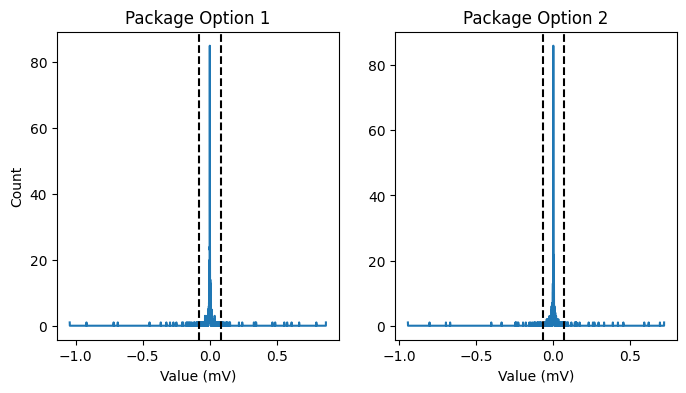

In [26]:
hist1, edges1 = np.histogram(np.concatenate(theCOM_6xs4p_pkg1.xt_samps), bins=10_001)
hist2, edges2 = np.histogram(np.concatenate(theCOM_6xs4p_pkg2.xt_samps), bins=10_001)
centers1 = (edges1[:-1] + edges1[1:])/2
centers2 = (edges2[:-1] + edges2[1:])/2
As1 = theCOM_6xs4p_pkg1.rslts['As']
As2 = theCOM_6xs4p_pkg2.rslts['As']

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(centers1*1e3, hist1)
plt.axvline(0.001*As1, color='black', linestyle='dashed')
plt.axvline(-0.001*As1, color='black', linestyle='dashed')
plt.title("Package Option 1")
plt.xlabel("Value (mV)")
plt.ylabel("Count")

plt.subplot(122)
plt.plot(centers2*1e3, hist2)
plt.axvline(0.001*As2, color='black', linestyle='dashed')
plt.axvline(-0.001*As2, color='black', linestyle='dashed')
plt.title("Package Option 2")
plt.xlabel("Value (mV)")

plt.show()


And I see, more or less, what I would expect: mostly singular values with a few doublets close in near zero and a complete void inside the recommended noise filtration threshold.
Furthermore, the maximum magnitudes seem reasomable at about 1 mV.

**Question for Bob:** Do you have, or can you generate, plots similar to the above, for comparison?

#### Effect on Histogram

Here, I just want to confirm that the addition of crosstalk to the interference "delta-distributions" really is widening them noticeably.
To confirm this, I plot pairs of these delta-distributions: `py0`/`py1`, captured in the Python code, as follows:

```python
py = p(hISI)  # `hISI` from (93A-27); `p(y)` as per (93A-40)
self.rslts['py0'] = py.copy()
xt_samps = []
pks = []
for pulse_resp in pulse_resps[1:]:  # (93A-44)
    i = np.argmax([sum(np.array(self.filt_pr_samps(pulse_resp[m::M], As))**2) for m in range(M)])  # (93A-33)
    samps = self.filt_pr_samps(pulse_resp[i::M], As)
    xt_samps.append(samps)
    pk = p(samps)
    pks.append(pk)
    py = np.convolve(py, pk, mode='same')
self.rslts['py1'] = py.copy()
```

As is clear from the code above, `py0` is the delta-dist. just before adding the crosstalk effect, while `py1` is immediately afterwards.
I'll plot them both and compare.

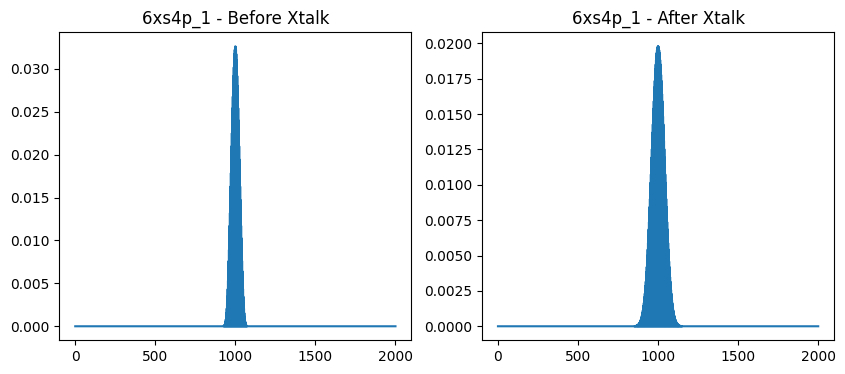

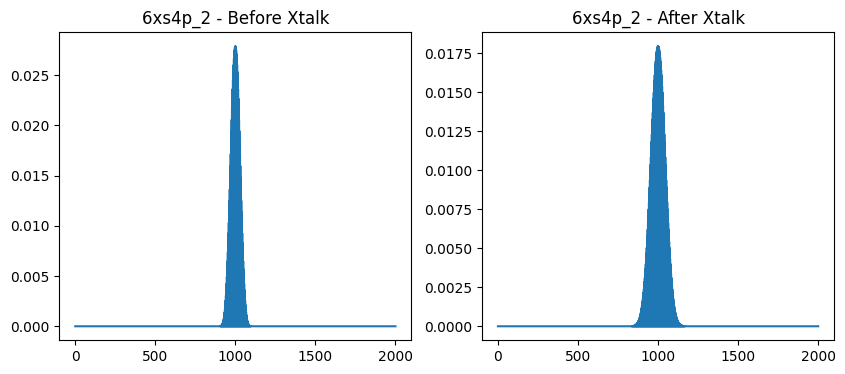

In [27]:
duts = [ (theCOM_6xs4p_pkg1, "6xs4p_1")
       , (theCOM_6xs4p_pkg2, "6xs4p_2")
       ]
for dut, lbl in duts:
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(dut.rslts['py0'])
    plt.title(lbl + " - Before Xtalk")
    plt.subplot(122)
    plt.plot(dut.rslts['py1'])
    plt.title(lbl + " - After Xtalk")
    plt.show()


Well, that certainly appears reasonable.

#### Aggressor Distributions

Before moving on, I'll just plot each of the 5 aggressor distributions, for both package options, just for reference.


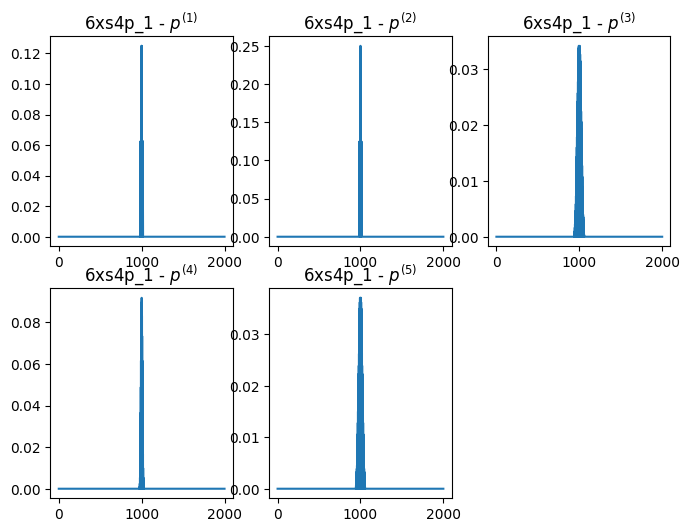

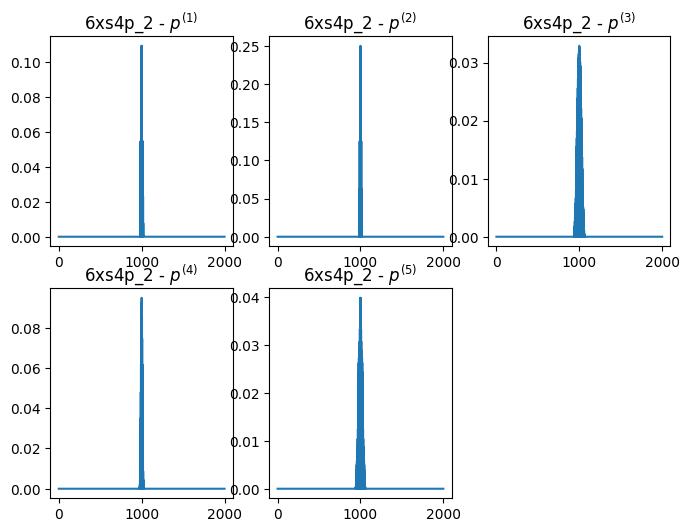

In [28]:
for dut, lbl in duts:
    plt.figure(figsize=(8, 6))
    for n in range(5):
        plt.subplot(230 + n+1)
        plt.plot(dut.pks[n])
        plt.title(f"{lbl} - $p^{{({n+1})}}$")
    plt.show()


That all looks pretty reasonable.

**Question for Bob:** Do you have, or can you generate, similar plots, for comparison?

#### Aggressor Pulse Responses

Here are the actual aggressor "thru" path pulse responses, also just for reference.
All plots have been given the same vertical and horizontal scales, to aid relative visual comparisons.

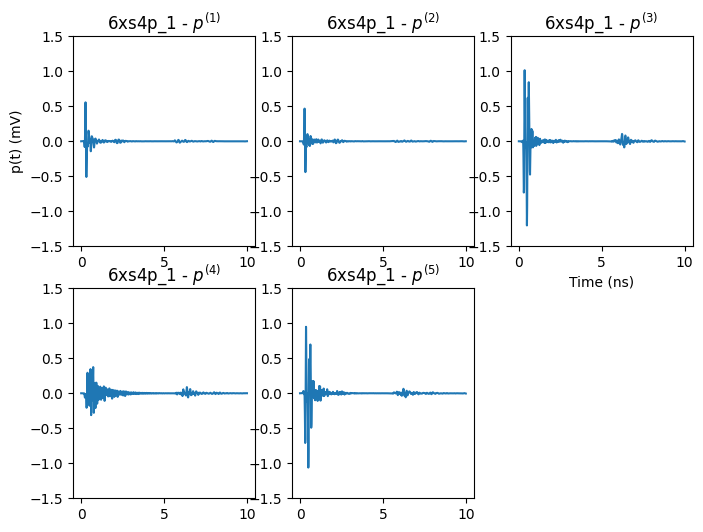

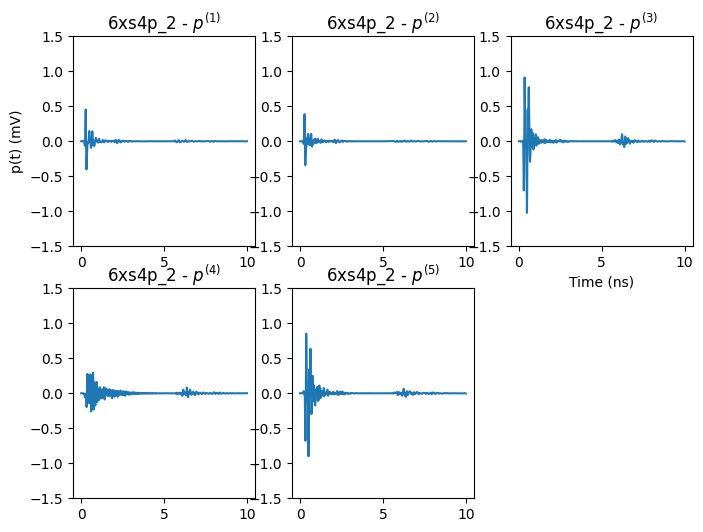

In [29]:
ymax = 1.5
for dut, lbl in duts:
    plt.figure(figsize=(8, 6))
    for n in range(5):
        plt.subplot(230 + n+1)
        plt.plot(dut.times*1e9, dut.pulse_resps[n+1]*1e3)
        plt.title(f"{lbl} - $p^{{({n+1})}}$")
        if n == 2:
            plt.xlabel("Time (ns)")
        if n == 0:
            plt.ylabel("p(t) (mV)")
        plt.axis(ymin=-ymax, ymax=ymax)
    plt.show()


**Question for Bob:** Do you have, or can you generate, similar plots, for comparison?


In [30]:
dname = "../PyBERT/misc/VITA_68p3/V68d3_COM_channel_files_for_David/"
for fname in [
    "FEXT1_s.csv",
    "FEXT2_s.csv",
    "NEXT1_s.csv",
    "NEXT2_s.csv",
    "NEXT3_s.csv",
]:
    t, vs = import_csv(dname + fname)
    plt.plot(t, vs[0])

FileNotFoundError: [Errno 2] No such file or directory: '../PyBERT/misc/VITA_68p3/V68d3_COM_channel_files_for_David/FEXT1_s.csv'